# Cargar Solo un Modelo

Este cuaderno tiene el codigo para cargar solo un modelo de los que ya estan preentrenados. Se construye el grafo, se agregan los embeddings de texto y con la arquitectura GraphSAGE se cargar el modelo.

## Instalación De Librerias y Frameworks

In [ ]:
# INSTALACIÓN DE LIBRERIAS NECESARIAS

!pip install networkx transformers pysentimiento pandas numpy scikit-learn matplotlib nltk seaborn plotly

In [ ]:
# Instalación de PyTorch 2.6.0 con soporte para CUDA 12.4, incluyendo torchvision y torchaudio

!pip install torch==2.6.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [ ]:
# Instalación de PyG (PyTorch Geometric) y sus dependencias compatibles con PyTorch 2.6.0 y CUDA 12.4

!pip install torch-scatter==2.1.2+pt26cu124 torch-sparse==0.6.18+pt26cu124 torch-geometric==2.5.3 -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

In [ ]:
# Instalación de pyg-lib 0.4.0 compatible con PyTorch 2.6.0 y CUDA 12.4 desde el repositorio oficial de PyG

!pip install pyg-lib==0.4.0+pt26cu124 -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

In [1]:
# IMPORTAR BIBILOTECAS

# files se utiliza para subir los archivos .csv solo a google colab.
"""
from google.colab import files
"""

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from transformers import AutoTokenizer, AutoModel
import torch
import torch_geometric

In [2]:
# Verifica si hay una GPU disponible, si la hay retorna True, sino False
print(torch.cuda.is_available())   # Debería mostrar True
print(torch.__version__)  # Debería mostrar '2.6.0' si PyTorch se instaló correctamente
print(torch.version.cuda)  # Debería mostrar '12.4', indicando que se está usando CUDA 12.4 (cu124)
import torch_geometric
print(torch_geometric.__version__)  # Debería imprimir la versión de PyTorch Geometric sin errores si está instalado correctamente

True
2.6.0+cu124
12.4
2.5.3


In [ ]:
# Subir los archivos CSV (SOLO en Google Colab)
uploaded = files.upload()   

### Cargar los .CSV a DataFrames

In [ ]:
"""
    PARA GOOGLE COLAB
"""
emprendimientos = pd.read_csv('emprendimientos.csv')
publicaciones = pd.read_csv('publicaciones.csv')
comentarios = pd.read_csv('comentarios.csv')
seguidores = pd.read_csv('seguidores.csv')
emprendimiento_tematica = pd.read_csv('emprendimiento_tematica.csv')
municipios = pd.read_csv('municipios.csv')
alcances = pd.read_csv('alcance.csv')
tematicas = pd.read_csv('tematicas.csv')

In [3]:
"""
    PARA JUPYTER NOTEBOOK
"""
emprendimientos = pd.read_csv('.\DATOS\emprendimientos.csv')
publicaciones = pd.read_csv('.\DATOS\publicaciones.csv')
comentarios = pd.read_csv('.\DATOS\comentarios.csv')
seguidores = pd.read_csv('.\DATOS\seguidores.csv')
emprendimiento_tematica = pd.read_csv('.\DATOS\emprendimiento_tematica.csv')
municipios = pd.read_csv('.\DATOS\municipios.csv')
alcances = pd.read_csv('.\\DATOS\\alcance.csv')
tematicas = pd.read_csv('.\\DATOS\\tematicas.csv')

## Construcción Del Grafo

In [4]:
# Inicializar el grafo
G = nx.Graph()

# Agregar nodos (emprendimientos)
for _, row in emprendimientos.iterrows():
    # Obtener temáticas asociadas
    temas = emprendimiento_tematica[emprendimiento_tematica['id_emprendimiento'] == row['id_emprendimiento']]['id_tematica'].tolist()
    # Atributos del nodo
    node_attrs = {
        'nombre_emprendimiento': row['nombre_emprendimiento'],
        'descripcion': row['descripcion'] if pd.notna(row['descripcion']) else '',
        'redes_sociales': row['redes_sociales'] if pd.notna(row['redes_sociales']) else '',
        'sitio_web': row['sitio_web'],
        'id_municipio_origen': row['id_municipio_origen'],
        'id_alcance': row['id_alcance'],
        'tematicas': temas
    }
    G.add_node(row['id_emprendimiento'], **node_attrs)

print(f"Nodos creados: {G.number_of_nodes()}") # Imprime el número de nodos

Nodos creados: 80


In [5]:
# Parte 1: Crear aristas basadas en interacciones

for _, pub in publicaciones.iterrows():
    id_emprendimiento = pub['id_emprendimiento']
    # Conectar emprendimientos que comparten temáticas en publicaciones (simplificación, ya que no tenemos datos de quién comentó)
    related_emprendimientos = emprendimiento_tematica[
        emprendimiento_tematica['id_tematica'].isin(
            emprendimiento_tematica[emprendimiento_tematica['id_emprendimiento'] == id_emprendimiento]['id_tematica']
        )
    ]['id_emprendimiento'].unique()
    # Excluir el emprendimiento actual de la lista de relacionados
    related_emprendimientos = related_emprendimientos[related_emprendimientos != id_emprendimiento]
 
    for rel_emp in related_emprendimientos:
        if rel_emp != id_emprendimiento and rel_emp in G.nodes:
            weight = pub['n_likes'] if pd.notna(pub['n_likes']) else 0
            G.add_edge(id_emprendimiento, rel_emp, weight=weight + 1)

In [6]:
# Parte 2: Crear aristas basadas en similitudes

for emp1 in G.nodes:
    for emp2 in G.nodes:
        if emp1 < emp2:  # Evitar duplicados
            emp1_attrs = G.nodes[emp1]
            emp2_attrs = G.nodes[emp2]
            # Similitud por temática
            temas_comunes = len(set(emp1_attrs['tematicas']) & set(emp2_attrs['tematicas']))
            # Similitud por municipio y alcance
            same_municipio = 1 if emp1_attrs['id_municipio_origen'] == emp2_attrs['id_municipio_origen'] else 0
            same_alcance = 1 if emp1_attrs['id_alcance'] == emp2_attrs['id_alcance'] else 0
            # Ponderar arista
            weight = temas_comunes + same_municipio + same_alcance
            if weight > 0:
                G.add_edge(emp1, emp2, weight=weight)

In [7]:
# Parte 3: Agregar peso basado en seguidores

for _, row in seguidores.iterrows():
    id_emprendimiento = row['id_emprendimiento']
    if id_emprendimiento in G.nodes:
        G.nodes[id_emprendimiento]['seguidores'] = row['cantidad']
        # Aumentar peso de aristas existentes según seguidores
        for emp2 in G.neighbors(id_emprendimiento):
            G[id_emprendimiento][emp2]['weight'] += row['cantidad'] / 1000  # Normalizar

print(f"Aristas creadas: {G.number_of_edges()}")

Aristas creadas: 2030


In [8]:
# Normalizar atributos numéricos
scaler = MinMaxScaler()

# Calcular total de likes por emprendimiento
likes_por_emprendimiento = publicaciones.groupby('id_emprendimiento')['n_likes'].sum().reset_index()
likes_por_emprendimiento.columns = ['id_emprendimiento', 'total_likes']

# Combinar likes y seguidores
emprendimientos_features = emprendimientos.merge(likes_por_emprendimiento, on='id_emprendimiento', how='left').fillna({'total_likes': 0})
emprendimientos_features = emprendimientos_features.merge(seguidores[['id_emprendimiento', 'cantidad']], on='id_emprendimiento', how='left').fillna({'cantidad': 0})

# Normalizar total_likes y cantidad
numeric_features = scaler.fit_transform(emprendimientos_features[['total_likes', 'cantidad']])
emprendimientos_features[['total_likes_norm', 'cantidad_norm']] = numeric_features

# Codificar atributos categóricos
onehot_encoder_municipio = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
municipio_encoded = onehot_encoder_municipio.fit_transform(emprendimientos[['id_municipio_origen']])
municipio_encoded_df = pd.DataFrame(municipio_encoded, columns=onehot_encoder_municipio.get_feature_names_out(['id_municipio_origen']))

onehot_encoder_alcance = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
alcance_encoded = onehot_encoder_alcance.fit_transform(emprendimientos[['id_alcance']])
alcance_encoded_df = pd.DataFrame(alcance_encoded, columns=onehot_encoder_alcance.get_feature_names_out(['id_alcance']))

# Codificar temáticas (matriz binaria)
tematica_encoded = np.zeros((len(emprendimientos), len(tematicas)))
for _, row in emprendimiento_tematica.iterrows():
    idx_emp = emprendimientos.index[emprendimientos['id_emprendimiento'] == row['id_emprendimiento']].tolist()[0]
    idx_tem = tematicas.index[tematicas['id_tematica'] == row['id_tematica']].tolist()[0]
    tematica_encoded[idx_emp, idx_tem] = 1
tematica_encoded_df = pd.DataFrame(tematica_encoded, columns=[f'tematica_{i}' for i in tematicas['id_tematica']])

# Combinar características numéricas y categóricas
features_df = pd.concat([emprendimientos_features[['id_emprendimiento', 'total_likes_norm', 'cantidad_norm']],
                         municipio_encoded_df, alcance_encoded_df, tematica_encoded_df], axis=1)

# Agregar características al grafo
for _, row in features_df.iterrows():
    if row['id_emprendimiento'] in G.nodes:
        G.nodes[row['id_emprendimiento']]['features'] = row.drop('id_emprendimiento').values

print("Dimensiones de las características:\n", features_df.shape)

Dimensiones de las características:
 (80, 41)


In [9]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.corpus import stopwords

# ---------------------------------
# 1. CARGAR DATOS Y EMBEDDINGS
# ---------------------------------
empr = pd.read_csv('./DATOS/emprendimientos.csv')
pubs = pd.read_csv('./DATOS/publicaciones.csv')
coms = pd.read_csv('./DATOS/comentarios.csv')

def load_emb(path):
    arr = np.load(path, allow_pickle=True)
    if arr.dtype == object:
        # convierte lista de vectores a array 2D float32
        arr = np.vstack([np.array(x, dtype=np.float32) for x in arr])
    return arr

desc_embs = load_emb('./Embeddings/512tk/descripcion_embeddings.npy')
cont_embs = load_emb('./Embeddings/512tk/contenido_embeddings.npy')
comm_embs = load_emb('./Embeddings/512tk/comentario_embeddings.npy')

nltk.download('stopwords', quiet=True)
span_stop = set(stopwords.words('spanish'))

# ---------------------------------
# 2. PREPARAR EMBEDDINGS TEXTUALES
# ---------------------------------
W_DESC, W_PUB, W_COM = 0.5, 0.3, 0.2
node_ids = sorted(G.nodes())
num_nodes = len(node_ids)
emb_dim    = desc_embs.shape[1]

if num_nodes == 0:
    raise ValueError("El grafo G no tiene nodos.")

# preallocate matriz de texto
raw_text = np.zeros((num_nodes, emb_dim), dtype=np.float32)

for i, nid in enumerate(node_ids):
    # descripción
    row = empr[empr.id_emprendimiento == nid]
    if not row.empty:
        idx = row.index[0]
        de  = desc_embs[idx]
    else:
        de  = np.zeros(emb_dim, dtype=np.float32)

    # publicaciones
    p_rows = pubs[pubs.id_emprendimiento == nid]
    if not p_rows.empty:
        idxs = p_rows.index.values
        pe   = np.nanmean(cont_embs[idxs], axis=0)
    else:
        pe   = np.zeros(emb_dim, dtype=np.float32)

    # comentarios
    pub_ids = p_rows.id_publicacion.values
    c_rows  = coms[coms.id_publicacion.isin(pub_ids)]
    if not c_rows.empty:
        idxs_c = c_rows.index.values
        ce     = np.nanmean(comm_embs[idxs_c], axis=0)
    else:
        ce     = np.zeros(emb_dim, dtype=np.float32)

    raw_text[i] = W_DESC*de + W_PUB*pe + W_COM*ce

# reducir dimensionalidad texto a 128
svd = TruncatedSVD(n_components=128, random_state=42)
text_feats = svd.fit_transform(raw_text)

for i, nid in enumerate(node_ids):
    G.nodes[nid]['text_features'] = text_feats[i]

# ---------------------------------
# 3. ESCALAR FEATURES NUMÉRICAS
# ---------------------------------
# recopilar
num_list, has_num = [], []
for nid in node_ids:
    f = G.nodes[nid].get('features')
    if f is not None:
        num_list.append(f)
        has_num.append(nid)

if num_list:
    num_mat = np.vstack(num_list)
    scaler  = MinMaxScaler().fit(num_mat)
    scaled  = scaler.transform(num_mat)
    for j, nid in enumerate(has_num):
        G.nodes[nid]['scaled_num'] = scaled[j]

# ---------------------------------
# 4. COMBINAR NUMÉRICAS + TEXTO
# ---------------------------------
A, B = 0.4, 0.6
for nid in node_ids:
    num = G.nodes[nid].get('scaled_num',
         np.zeros_like(text_feats[0], dtype=np.float32))
    txt = G.nodes[nid]['text_features']
    G.nodes[nid]['combined_features'] = np.hstack([A*num, B*txt])

# ---------------------------------
# 5. CREAR Data DE PyG
# ---------------------------------
x_list = [G.nodes[n]['combined_features'] for n in node_ids]
x = torch.tensor(np.vstack(x_list), dtype=torch.float)

edges, weights = [], []
for u, v, e in G.edges(data=True):
    w = e.get('weight', 1.0)
    edges += [[u, v], [v, u]]
    weights += [w, w]

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_attr  = torch.tensor(weights, dtype=torch.float)

data = Data(
    x=x,
    edge_index=edge_index,
    edge_attr=edge_attr,
    num_nodes=num_nodes,
    node_ids=torch.tensor(node_ids, dtype=torch.long)
)

# Verificación
print(f"Nodos: {data.num_nodes}")
print(f"Dims por nodo: {data.num_node_features}")
print(f"Aristas (bidireccional): {data.edge_index.shape[1]}")


Nodos: 80
Dims por nodo: 120
Aristas (bidireccional): 4060


In [10]:
import torch
import networkx as nx


# Verificar nodos en el grafo
print("Nodos en G:", list(G.nodes)[:10])
print("Número de nodos:", G.number_of_nodes())

# Crear un mapeo de nodos a índices contiguos (0, 1, ..., N-1)
nodes = list(G.nodes)
mapping = {node: idx for idx, node in enumerate(nodes)}

# Verificar que todos los nodos en las aristas estén en el mapeo
edges_to_remove = [e for e in G.edges if e[0] not in mapping or e[1] not in mapping]
if edges_to_remove:
    print("Eliminando aristas con nodos inválidos:", edges_to_remove)
    G.remove_edges_from(edges_to_remove)

# Actualizar edge_index y edge_attr
edge_index_list = [[mapping[e[0]], mapping[e[1]]] for e in G.edges]
edge_weight_list = [G[e[0]][e[1]]['weight'] for e in G.edges]
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t()
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)

print("Edge index creado con éxito:", edge_index.shape)

Nodos en G: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Número de nodos: 80
Edge index creado con éxito: torch.Size([2, 2030])


In [11]:
# Obtener características de los nodos
node_features = torch.tensor([G.nodes[n]['combined_features'] for n in sorted(G.nodes)], dtype=torch.float)

# Crear objeto Data
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weight)

print(f"Dimensiones de node_features: {data.x.shape}")
print(f"Dimensiones de edge_index: {data.edge_index.shape}")
print(f"Dimensiones de edge_weight: {data.edge_attr.shape}")
print(f"Número de nodos: {data.num_nodes}")
print(f"Número de aristas: {data.num_edges}")

Dimensiones de node_features: torch.Size([80, 120])
Dimensiones de edge_index: torch.Size([2, 2030])
Dimensiones de edge_weight: torch.Size([2030])
Número de nodos: 80
Número de aristas: 2030


C:\Users\Angel\AppData\Local\Temp\ipykernel_22984\2187253825.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  node_features = torch.tensor([G.nodes[n]['combined_features'] for n in sorted(G.nodes)], dtype=torch.float)


In [12]:
from torch_geometric.transforms import RandomLinkSplit
from sklearn.preprocessing import StandardScaler

# Normalizar node_features
scaler = StandardScaler()
data.x = torch.tensor(scaler.fit_transform(data.x), dtype=torch.float)

# Verificar varianza de características
print("Media y desv. estándar de node_features:", data.x.mean(), data.x.std())

# Dividir las aristas
transform = RandomLinkSplit(
    num_val=0.15,  # 15% para validación
    num_test=0.15,  # 15% para prueba
    is_undirected=True,  # Grafo no dirigido
    add_negative_train_samples=True,  # Generar aristas negativas
    neg_sampling_ratio=0.5  # Igual número de aristas negativas que positivas
)

try:
    train_data, val_data, test_data = transform(data)
    print(f"Aristas de entrenamiento positivas: {train_data.edge_label_index.shape}")
    print(f"Aristas de validación: {val_data.edge_label_index.shape}")
    print(f"Aristas de prueba: {test_data.edge_label_index.shape}")
except Exception as e:
    print(f"Error al dividir aristas: {e}")
    print("Número de aristas:", data.num_edges)

Media y desv. estándar de node_features: tensor(1.9372e-09) tensor(1.0001)
Aristas de entrenamiento positivas: torch.Size([2, 2133])
Aristas de validación: torch.Size([2, 456])
Aristas de prueba: torch.Size([2, 456])


## Cargar Modelo Preentrenado

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# Definir la clase GraphSAGE (misma que en el entrenamiento)
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        
        self.dropout = dropout
        self.predictor = nn.Sequential(
            nn.Linear(2 * out_channels, out_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(out_channels, 1)
        )
    
    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x
    
    def predict(self, x_src, x_dst):
        h = torch.cat([x_src, x_dst], dim=1)
        return torch.sigmoid(self.predictor(h)).view(-1)

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir hiperparámetros
in_channels = 120  # Confirmado por la salida del modelo (SAGEConv(120, 256))
hidden_channels = 256
out_channels = 128

# Crear instancia del modelo
model = GraphSAGE(in_channels, hidden_channels, out_channels).to(device)

# Cargar el archivo .pth
model_path = r"D:\Universidad\Proyecto De Grado\Construccion del modelo\Modelo_Repositorio\Modelos\Segundo Metodo Modelos\model_5_20250627_184503.pth"
checkpoint = torch.load(model_path, map_location=device, weights_only=False)

# Extraer el state_dict del diccionario cargado
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Poner el modelo en modo evaluación

# Usar test_data del entrenamiento para las predicciones
data = test_data.to(device)  # Mover test_data al dispositivo

# Obtener embeddings y realizar predicciones
with torch.no_grad():
    h = model(data.x, data.edge_index)  # Generar embeddings para todos los nodos
    pred = model.predict(h[data.edge_label_index[0]], h[data.edge_label_index[1]])  # Predecir para las aristas
    pred_np = pred.cpu().numpy()  # Convertir a numpy
    pred_binary = (pred_np > 0.5).astype(int)  # Predicciones binarias (umbral 0.5)

# Mostrar resultados
print("Predicciones (probabilidades):", pred_np)
print("Predicciones (binarias):", pred_binary)

# Opcional: Comparar con etiquetas reales (si están disponibles)
if hasattr(data, 'edge_label'):
    y_np = data.edge_label.cpu().numpy()
    print("Etiquetas reales:", y_np)
    # Calcular métricas
    from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, average_precision_score
    auc = roc_auc_score(y_np, pred_np)
    ap = average_precision_score(y_np, pred_np)
    precision = precision_score(y_np, pred_binary)
    recall = recall_score(y_np, pred_binary)
    f1 = f1_score(y_np, pred_binary)
    print(f"Métricas de prueba: Precision: {precision:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}, Recall: {recall:.4f}, AP: {ap:.4f}")

Predicciones (probabilidades): [9.72430646e-01 9.87460792e-01 9.82656360e-01 9.98694718e-01
 8.58600199e-01 7.17299044e-01 9.69391942e-01 9.98551548e-01
 9.89718199e-01 9.92736936e-01 9.96724904e-01 9.98205304e-01
 9.90417540e-01 9.66899216e-01 9.89457965e-01 9.46673334e-01
 9.92277026e-01 9.82659817e-01 9.91968811e-01 9.66478586e-01
 8.70656371e-01 9.79009748e-01 9.56410408e-01 9.92285848e-01
 9.76937294e-01 8.47111046e-01 9.31853354e-01 9.88525450e-01
 8.00468743e-01 8.76732469e-01 9.66739893e-01 9.67483938e-01
 4.08048183e-01 9.93135095e-01 9.03675199e-01 9.75694895e-01
 4.18440878e-01 3.14389735e-01 3.76701117e-01 8.32423925e-01
 9.87792671e-01 8.52344036e-01 9.97681260e-01 9.90693033e-01
 9.99345720e-01 9.99089837e-01 5.58032930e-01 9.92393374e-01
 9.80159521e-01 7.54497826e-01 9.81372714e-01 9.95152473e-01
 9.98517931e-01 9.69497681e-01 9.81568933e-01 5.01055360e-01
 9.91683722e-01 9.96101737e-01 9.93596554e-01 9.84075606e-01
 9.78994668e-01 9.96821761e-01 5.54867923e-01 9.925954

## Predicciones

In [14]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_emprendimiento_info(id_emprendimiento, emprendimientos_df):
    """Obtiene información de un emprendimiento dado su ID"""
    emp = emprendimientos_df[emprendimientos_df['id_emprendimiento'] == id_emprendimiento].iloc[0]
    return {
        'id': id_emprendimiento,
        'nombre': emp['nombre_emprendimiento'],
        'descripcion': emp['descripcion'],
        'municipio': emp['id_municipio_origen'],
        'alcance': emp['id_alcance']
    }

def recommend_emprendimientos(model, data, emprendimientos_df, target_id, top_k=15):
    """
    Recomienda emprendimientos similares a uno dado
    
    Args:
        model: Modelo GraphSAGE entrenado
        data: Datos del grafo (en formato PyG)
        emprendimientos_df: DataFrame con información de emprendimientos
        target_id: ID del emprendimiento objetivo
        top_k: Número de recomendaciones a devolver
    """
    # Verificar dispositivo del modelo
    device = next(model.parameters()).device
    
    # Verificar si el emprendimiento objetivo existe en el DataFrame
    if target_id not in emprendimientos_df['id_emprendimiento'].values:
        print(f"Error: No se encontró el emprendimiento con ID {target_id} en el DataFrame")
        return None
    
    # Mover datos al mismo dispositivo que el modelo
    data = data.to(device)
    
    # Obtener embeddings de todos los nodos
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).cpu().numpy()
    
    # Asumimos que el orden de los nodos en data.x corresponde a los IDs ordenados
    # Si no es así, necesitaríamos mapear los índices a los IDs
    node_ids = emprendimientos_df['id_emprendimiento'].values
    
    try:
        target_idx = np.where(node_ids == target_id)[0][0]
    except IndexError:
        print(f"Error: El ID {target_id} no existe en los nodos del grafo")
        return None
    
    # Calcular similitud coseno
    target_embedding = embeddings[target_idx].reshape(1, -1)
    similarities = cosine_similarity(target_embedding, embeddings)[0]
    
    # Ordenar por similitud (excluyendo el propio emprendimiento)
    sorted_indices = np.argsort(similarities)[::-1]
    sorted_indices = [i for i in sorted_indices if node_ids[i] != target_id][:top_k]
    
    # Obtener información de los emprendimientos recomendados
    recommendations = []
    for idx in sorted_indices:
        emp_id = node_ids[idx]
        similarity = similarities[idx]
        emp_info = get_emprendimiento_info(emp_id, emprendimientos_df)
        emp_info['similitud'] = f"{similarity:.3f}"
        recommendations.append(emp_info)
    
    return recommendations

    
def print_recommendations(target_emp, recommendations):
    """Muestra las recomendaciones de forma legible"""
    print(f"\nRecomendaciones para el emprendimiento:")
    print(f"ID: {target_emp['id']}")
    print(f"Nombre: {target_emp['nombre']}")
    print(f"Descripción: {target_emp['descripcion']}")
    print(f"Municipio: {target_emp['municipio']}")
    print(f"Alcance: {target_emp['alcance']}")
    
    print("\nEmprendimientos recomendados:")
    for i, rec in enumerate(recommendations, 1):
        print(f"\n#{i} (Similitud: {rec['similitud']})")
        print(f"ID: {rec['id']}")
        print(f"Nombre: {rec['nombre']}")
        print(f"Descripción: {rec['descripcion']}")
        print(f"Municipio: {rec['municipio']}")
        print(f"Alcance: {rec['alcance']}")

# Ejemplo de uso después del entrenamiento:
# 1. Cargar el dataframe de emprendimientos (debes tenerlo cargado como emprendimientos_df)
# emprendimientos_df = pd.read_csv('ruta/a/tu/archivo.csv')

# 2. Seleccionar un emprendimiento para recomendar
# target_id = 5  # Cambia esto por el ID que quieras probar

# 3. Obtener recomendaciones
# target_emp = get_emprendimiento_info(target_id, emprendimientos_df)
# recommendations = recommend_emprendimientos(model, data, emprendimientos_df, target_id)

# 4. Mostrar resultados
# print_recommendations(target_emp, recommendations)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

# Cargar el dataframe de emprendimientos
emprendimientos_df = pd.read_csv('.\DATOS\emprendimientos.csv')

# Generar recomendaciones
target_id = 46 # Cambia esto por el ID que quieras probar
target_emp = get_emprendimiento_info(target_id, emprendimientos_df)
recommendations = recommend_emprendimientos(model, data, emprendimientos_df, target_id)

if recommendations:
    print_recommendations(target_emp, recommendations)


Recomendaciones para el emprendimiento:
ID: 46
Nombre: Mujeres Tejedoras
Descripción: Taller de empoderamiento femenino a través de tejidos
Municipio: 1
Alcance: 1

Emprendimientos recomendados:

#1 (Similitud: 0.961)
ID: 57
Nombre: Manos Diversas
Descripción: Artesanías elaboradas por comunidades vulnerables
Municipio: 3
Alcance: 1

#2 (Similitud: 0.959)
ID: 56
Nombre: EcoFeminista
Descripción: Huerto urbano gestionado por mujeres
Municipio: 2
Alcance: 1

#3 (Similitud: 0.945)
ID: 58
Nombre: Juntas Decidimos
Descripción: Espacios de participación ciudadana para mujeres
Municipio: 6
Alcance: 1

#4 (Similitud: 0.944)
ID: 63
Nombre: Mujeres que tejen
Descripción: Cooperativa de mujeres indígenas en Silvia que crean textiles tradicionales.
Municipio: 2
Alcance: 1

#5 (Similitud: 0.943)
ID: 38
Nombre: Manos Nasa
Descripción: Productos tejidos por comunidades indígenas
Municipio: 3
Alcance: 1

#6 (Similitud: 0.928)
ID: 68
Nombre: Derechos para Todos
Descripción: Campañas de educación en de

### Clustering

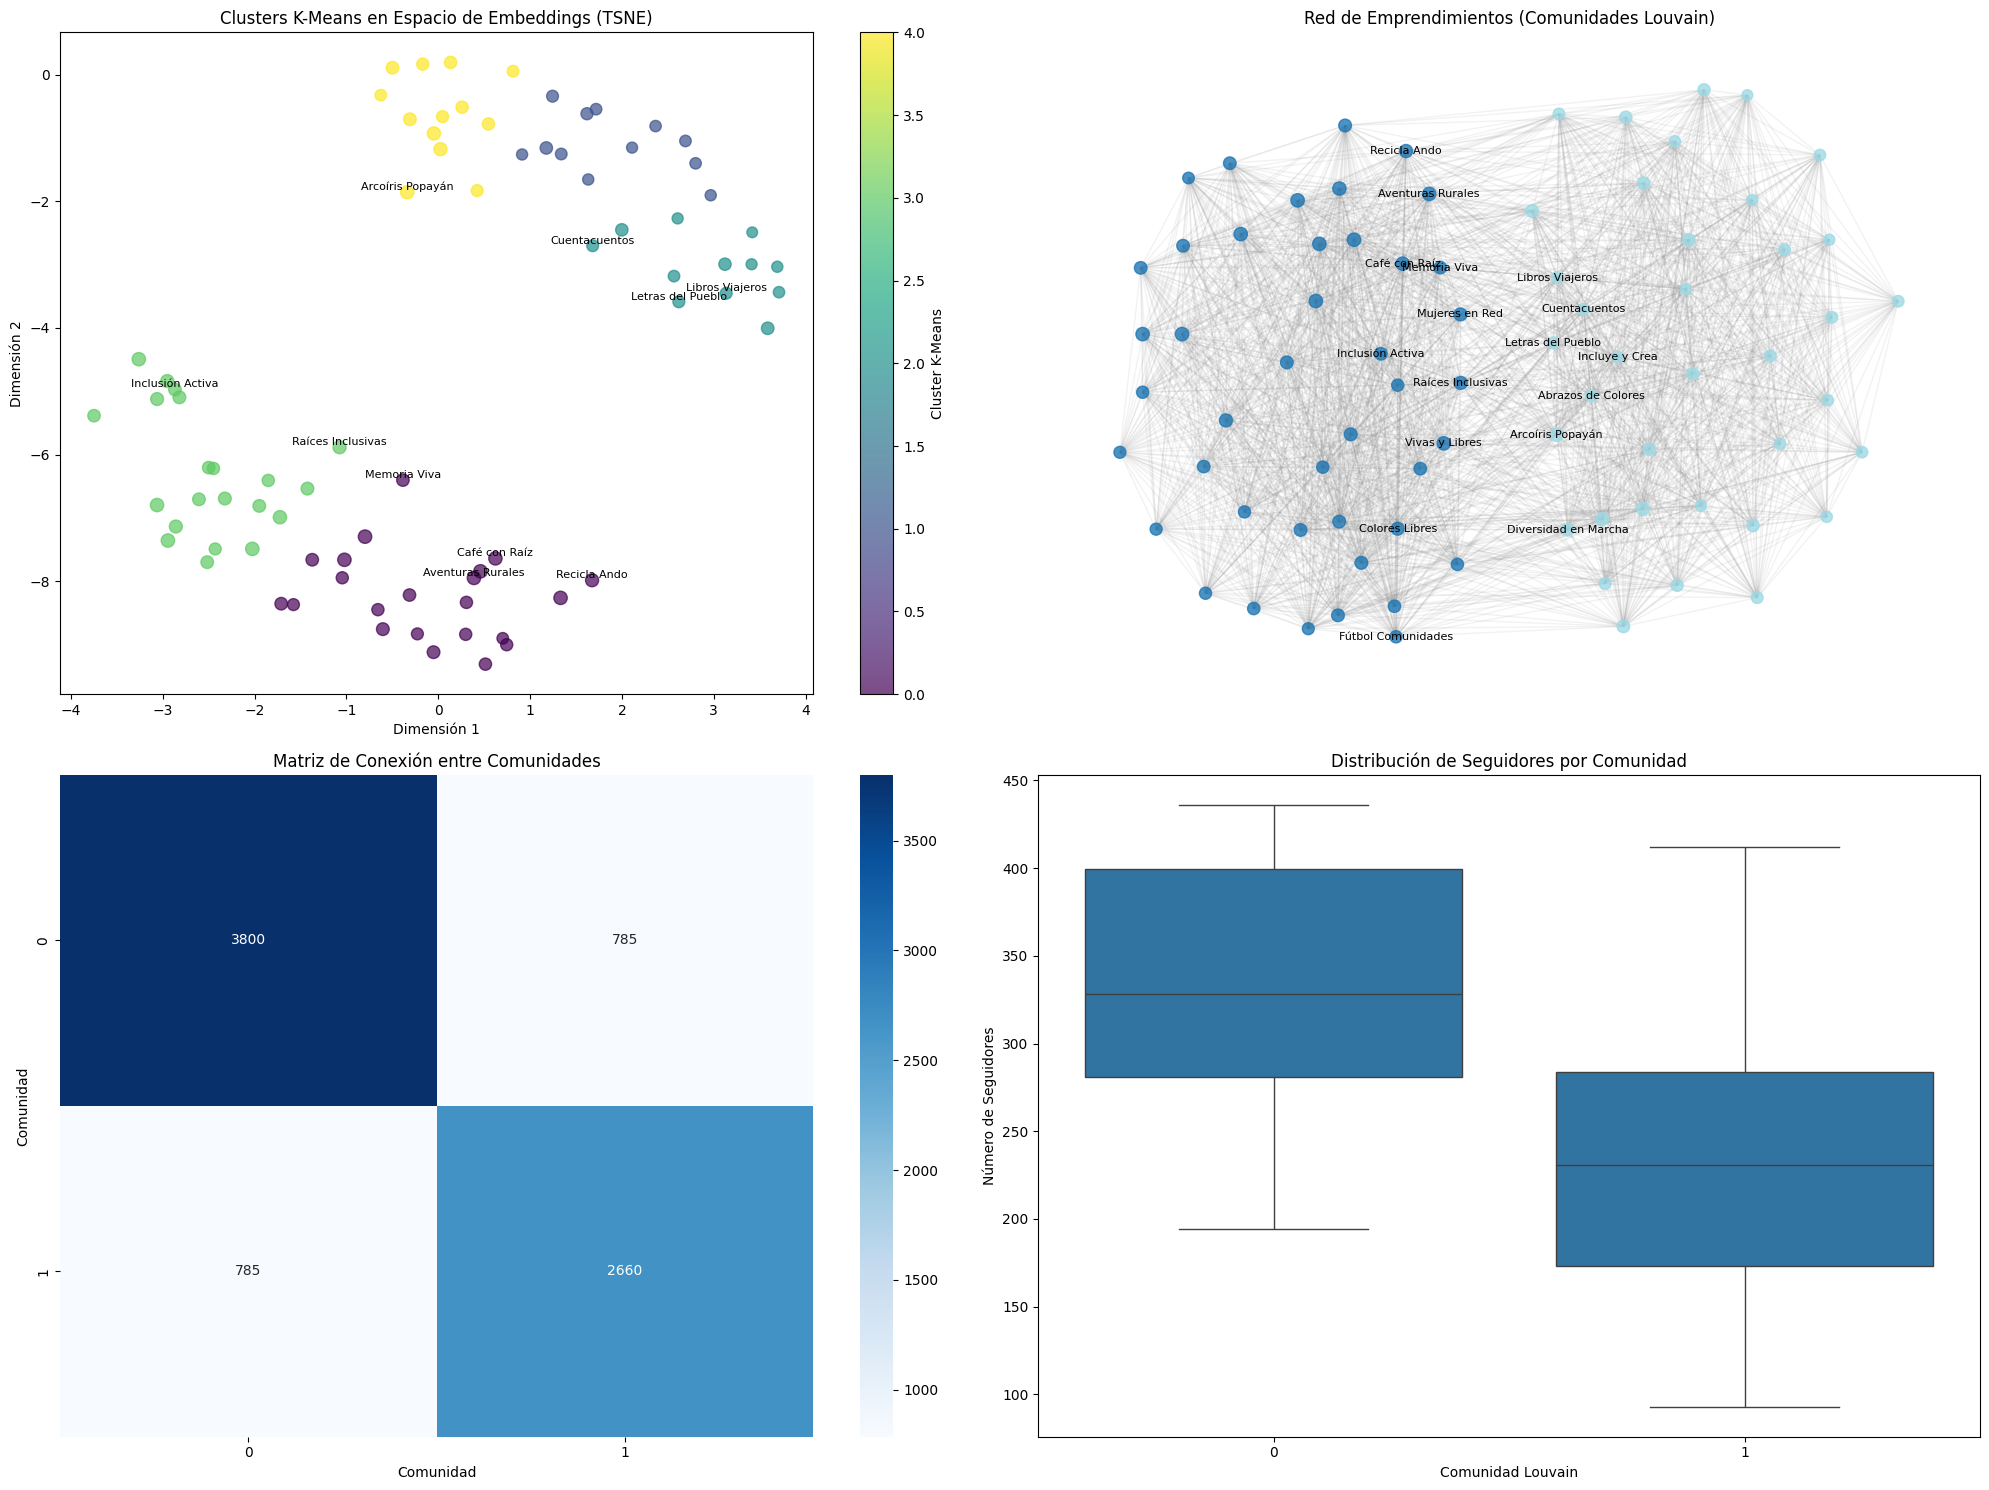


ANÁLISIS DETALLADO DE COMUNIDADES Y CLUSTERS

📊 Métricas de Clustering:
K-Means - Silhouette: 0.3289, Davies-Bouldin: 0.9941
Agglomerative - Silhouette: 0.3124, Davies-Bouldin: 0.9829
DBSCAN - N° Clusters: 0, Silhouette: 0.0000

🔄 Solapamiento entre K-Means y Louvain:
comunidad_louvain   0   1
cluster_kmeans           
0                  22   0
1                   0  12
2                   0  12
3                  21   0
4                   0  13

🔵 COMUNIDAD 0 (43 miembros)
📌 Temáticas principales: Inclusión social, Justicia ambiental, Conservación ambiental, Derechos humanos, Educación
📊 Distribución de temáticas: {15: 12, 17: 11, 10: 11, 16: 9, 6: 7, 12: 5, 1: 4, 7: 4, 5: 4, 13: 4, 14: 3, 11: 3, 9: 3, 19: 2, 3: 2, 2: 1, 18: 1}
📍 Municipio más común: 1
🌐 Alcance predominante: Regional
👥 Seguidores totales: 14,476
📈 Centralidad promedio (degree): 0.6674
📈 Centralidad promedio (betweenness): 0.0013

🚀 Emprendimientos destacados:
- Explora Naturaleza (436 seguidores, Centralidad: 0.696

In [16]:
import numpy as np
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.sparse.csgraph import connected_components
import community as community_louvain  # Para Louvain
from collections import Counter
import plotly.express as px  # Para visualizaciones interactivas
import plotly.graph_objects as go

def detect_communities_with_embeddings(model, G, test_data, emprendimientos_df, tematicas_df, emprendimiento_tematica_df, n_clusters=5, resolution=1.0, use_3d=False):
    """
    Detecta comunidades con múltiples métodos de clustering y visualizaciones avanzadas.
    
    Args:
        model: Modelo GraphSAGE entrenado
        G: Grafo NetworkX
        test_data: Objeto Data de PyTorch Geometric con x, edge_index, edge_label_index
        emprendimientos_df: DataFrame con datos de emprendimientos
        tematicas_df: DataFrame con datos de temáticas
        emprendimiento_tematica_df: DataFrame con relaciones emprendimiento-temática
        n_clusters: Número de clusters para K-Means y Agglomerative
        resolution: Resolución para Louvain
        use_3d: Si True, genera visualización 3D interactiva
    
    Returns:
        results_df: DataFrame con asignaciones de clusters y comunidades
        embeddings: Embeddings generados por el modelo
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 1. Generar embeddings
    model.eval()
    with torch.no_grad():
        z = model(test_data.x.to(device), test_data.edge_index.to(device)).cpu().numpy()
    
    # 2. Múltiples métodos de clustering
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(z)
    kmeans_silhouette = silhouette_score(z, kmeans_labels) if n_clusters > 1 else 0
    kmeans_db = davies_bouldin_score(z, kmeans_labels) if n_clusters > 1 else 0

    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_labels = agglomerative.fit_predict(z)
    agg_silhouette = silhouette_score(z, agg_labels) if n_clusters > 1 else 0
    agg_db = davies_bouldin_score(z, agg_labels) if n_clusters > 1 else 0

    # DBSCAN (para detectar outliers)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(z)
    n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    dbscan_silhouette = silhouette_score(z, dbscan_labels) if n_dbscan_clusters > 1 else 0

    # 3. Detección de comunidades con Louvain
    partition = community_louvain.best_partition(G.to_undirected(), weight='weight', resolution=resolution)
    louvain_labels = np.array([partition[node] for node in G.nodes()])
    n_louvain_communities = len(set(partition.values()))

    # 4. Preparar datos para análisis
    results_df = pd.DataFrame({
        'id_emprendimiento': list(G.nodes()),
        'cluster_kmeans': kmeans_labels,
        'cluster_agglomerative': agg_labels,
        'cluster_dbscan': dbscan_labels,
        'comunidad_louvain': louvain_labels
    }).merge(
        emprendimientos_df[['id_emprendimiento', 'nombre_emprendimiento', 'descripcion', 'id_municipio_origen', 'id_alcance']],
        on='id_emprendimiento'
    ).merge(
        seguidores[['id_emprendimiento', 'cantidad']],
        on='id_emprendimiento',
        how='left'
    ).fillna({'cantidad': 0})

    # 5. Análisis de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    results_df['degree_centrality'] = [degree_centrality[node] for node in results_df['id_emprendimiento']]
    results_df['betweenness_centrality'] = [betweenness_centrality[node] for node in results_df['id_emprendimiento']]

    # 6. Análisis de temáticas por comunidad
    comunidad_tematica = []
    for com_id in set(louvain_labels):
        emps = results_df[results_df['comunidad_louvain'] == com_id]['id_emprendimiento']
        temas = emprendimiento_tematica_df[emprendimiento_tematica_df['id_emprendimiento'].isin(emps)]['id_tematica']
        tema_counts = temas.value_counts()
        top_temas = tema_counts.head(5).index
        tema_names = [tematicas_df[tematicas_df['id_tematica'] == t]['nombre'].values[0] for t in top_temas]
        comunidad_tematica.append({
            'comunidad': com_id,
            'tematicas': ', '.join(tema_names),
            'tematica_counts': tema_counts.to_dict()
        })

    # 7. Visualizaciones avanzadas
    plt.figure(figsize=(20, 15))

    # Gráfico 1: Embeddings 2D con TSNE
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(z)

    plt.subplot(2, 2, 1)
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=kmeans_labels, cmap='viridis', s=results_df['cantidad'] / 10 + 50, alpha=0.7)
    plt.colorbar(scatter, label='Cluster K-Means')
    central_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    for node, _ in central_nodes:
        idx = list(G.nodes()).index(node)
        plt.text(z_2d[idx, 0], z_2d[idx, 1], 
                 results_df[results_df['id_emprendimiento'] == node]['nombre_emprendimiento'].values[0],
                 fontsize=8, ha='center', va='bottom')
    plt.title('Clusters K-Means en Espacio de Embeddings (TSNE)')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')

    # Gráfico 2: Red con comunidades Louvain
    plt.subplot(2, 2, 2)
    pos = nx.spring_layout(G, weight='weight', seed=42)
    node_sizes = [results_df[results_df['id_emprendimiento'] == n]['cantidad'].values[0] / 10 + 50 for n in G.nodes()]
    nx.draw_networkx_nodes(
        G, pos, node_color=louvain_labels, node_size=node_sizes, cmap='tab20', alpha=0.8
    )
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray')
    for node, (x, y) in pos.items():
        if degree_centrality[node] > np.percentile(list(degree_centrality.values()), 75):
            plt.text(x, y, 
                     results_df[results_df['id_emprendimiento'] == node]['nombre_emprendimiento'].values[0],
                     fontsize=8, ha='center', va='center')
    plt.title('Red de Emprendimientos (Comunidades Louvain)')
    plt.axis('off')

    # Gráfico 3: Mapa de calor de similitud entre comunidades
    plt.subplot(2, 2, 3)
    community_matrix = np.zeros((n_louvain_communities, n_louvain_communities))
    for u, v in G.edges():
        com_u, com_v = partition[u], partition[v]
        community_matrix[com_u, com_v] += G[u][v].get('weight', 1.0)
        community_matrix[com_v, com_u] += G[u][v].get('weight', 1.0)
    sns.heatmap(community_matrix, cmap='Blues', annot=True, fmt='.0f')
    plt.title('Matriz de Conexión entre Comunidades')
    plt.xlabel('Comunidad')
    plt.ylabel('Comunidad')

    # Gráfico 4: Distribución de seguidores por comunidad
    plt.subplot(2, 2, 4)
    sns.boxplot(x='comunidad_louvain', y='cantidad', data=results_df)
    plt.title('Distribución de Seguidores por Comunidad')
    plt.xlabel('Comunidad Louvain')
    plt.ylabel('Número de Seguidores')

    plt.tight_layout()
    plt.show()

    # Visualización 3D interactiva (opcional)
    if use_3d:
        z_3d = PCA(n_components=3).fit_transform(z)
        fig = px.scatter_3d(
            x=z_3d[:, 0], y=z_3d[:, 1], z=z_3d[:, 2],
            color=kmeans_labels, size=results_df['cantidad'] / 10 + 50,
            text=results_df['nombre_emprendimiento'],
            title='Clusters K-Means en 3D (PCA)'
        )
        fig.update_traces(textposition='top center')
        fig.show()

    # 8. Análisis detallado
    print("\n" + "="*100)
    print("ANÁLISIS DETALLADO DE COMUNIDADES Y CLUSTERS")
    print("="*100)

    # Métricas de clustering
    print("\n📊 Métricas de Clustering:")
    print(f"K-Means - Silhouette: {kmeans_silhouette:.4f}, Davies-Bouldin: {kmeans_db:.4f}")
    print(f"Agglomerative - Silhouette: {agg_silhouette:.4f}, Davies-Bouldin: {agg_db:.4f}")
    print(f"DBSCAN - N° Clusters: {n_dbscan_clusters}, Silhouette: {dbscan_silhouette:.4f}")

    # Solapamiento entre K-Means y Louvain
    overlap = pd.crosstab(results_df['cluster_kmeans'], results_df['comunidad_louvain'])
    print("\n🔄 Solapamiento entre K-Means y Louvain:")
    print(overlap)

    # Análisis por comunidad Louvain
    for com_id in sorted(set(louvain_labels)):
        print(f"\n🔵 COMUNIDAD {com_id} ({len(results_df[results_df['comunidad_louvain'] == com_id])} miembros)")
        com_data = results_df[results_df['comunidad_louvain'] == com_id]
        
        # Temáticas
        temas_info = comunidad_tematica[com_id]
        print(f"📌 Temáticas principales: {temas_info['tematicas']}")
        print(f"📊 Distribución de temáticas: {temas_info['tematica_counts']}")

        # Estadísticas
        print(f"📍 Municipio más común: {com_data['id_municipio_origen'].mode()[0]}")
        print(f"🌐 Alcance predominante: {'Local' if com_data['id_alcance'].mode()[0] == 1 else 'Regional'}")
        print(f"👥 Seguidores totales: {com_data['cantidad'].sum():,}")
        print(f"📈 Centralidad promedio (degree): {com_data['degree_centrality'].mean():.4f}")
        print(f"📈 Centralidad promedio (betweenness): {com_data['betweenness_centrality'].mean():.4f}")

        # Emprendimientos destacados
        top_emps = com_data.sort_values('cantidad', ascending=False).head(5)
        print("\n🚀 Emprendimientos destacados:")
        for _, emp in top_emps.iterrows():
            print(f"- {emp['nombre_emprendimiento']} ({emp['cantidad']:,} seguidores, Centralidad: {emp['degree_centrality']:.4f})")

        # Análisis de clusters dentro de la comunidad
        cluster_counts = com_data['cluster_kmeans'].value_counts()
        print("\n📊 Distribución de clusters K-Means en esta comunidad:")
        for cluster_id, count in cluster_counts.items():
            print(f"Cluster {cluster_id}: {count} miembros")

    # Análisis de cohesión
    print("\n🔗 Análisis de Cohesión del Grafo:")
    n_components, _ = connected_components(nx.to_scipy_sparse_array(G.to_undirected()))
    print(f"Número de componentes conexas: {n_components}")
    print(f"Modularidad (Louvain): {community_louvain.modularity(partition, G.to_undirected(), weight='weight')}")

    return results_df, z

# Ejecutar con todos los datos necesarios
# Asumiendo que model, G, test_data, emprendimientos, tematicas, emprendimiento_tematica están definidos
communities_df, embeddings = detect_communities_with_embeddings(
    model, G, test_data, 
    emprendimientos, tematicas, emprendimiento_tematica,
    n_clusters=5, resolution=1.0, use_3d=False
)